In [1]:
pip install torchmetrics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 32.1 MB/s eta 0:00:00


In [2]:
pip install torch-fidelity -q

In [3]:
pip install torchmetrics[image] -q

In [4]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import numpy as np

import torchmetrics
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math

In [26]:
class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[..., None, None]

class ScoreNet(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        super().__init__()
        self.embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )
        # Encoding layers
        self.conv1  = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4,  num_channels=channels[0])
        self.conv2  = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3  = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4  = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers
        self.tconv4  = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5  = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3  = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6  = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2  = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7  = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1  = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x, t):
        embed = self.act(self.embed(t))
        # Encoding
        h1 = self.conv1(x)
        h1 += self.dense1(embed)
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)

        h2 = self.conv2(h1)
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)

        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)

        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)

        # Decoding
        h = self.tconv4(h4)
        h += self.dense5(embed)
        h = self.tgnorm4(h)
        h = self.act(h)
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.act(h)
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.tgnorm2(h)
        h = self.act(h)
        h = self.tconv1(torch.cat([h, h1], dim=1))

        # For DDPM epsilon-pred, set sigma(t) = 1 => effectively no division
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

class ExponentialMovingAverage(torch.optim.swa_utils.AveragedModel):
    """Maintains moving averages of model parameters using an exponential decay."""
    def __init__(self, model, decay, device="cpu"):
        def ema_avg(avg_model_param, model_param, num_averaged):
            return decay * avg_model_param + (1 - decay) * model_param
        super().__init__(model, device, ema_avg, use_buffers=True)

In [33]:
class DDPM(nn.Module):
    def __init__(self, network, T=100, beta_1=1e-4, beta_T=2e-2, use_importance_sampling=False):
        """
        Initialize Denoising Diffusion Probabilistic Model
        with optional importance sampling for t.
        """
        super().__init__()
        self._network = network
        self.T = T
        self.network = lambda x, t: (self._network(
            x.reshape(-1, 1, 28, 28),
            (t.squeeze()/T))
        ).reshape(-1, 28*28)

        # Buffers
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T+1))
        self.register_buffer("alpha", 1 - self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))

        # Turn on importance sampling if desired
        self.use_importance_sampling = use_importance_sampling
        if self.use_importance_sampling:
            # e.g. p(t) = sqrt(1 - alpha_bar[t]) for t=1..T
            p_vals = torch.sqrt(1.0 - self.alpha_bar)
            p_vals[0] = 0.0  # we don't use t=0
            p_vals = p_vals / p_vals.sum()  # normalize
            self.register_buffer("p_t", p_vals)  # shape (T+1,)

    def forward_diffusion(self, x0, t, epsilon):
        mean = torch.sqrt(self.alpha_bar[t]) * x0
        std  = torch.sqrt(1 - self.alpha_bar[t])
        return mean + std*epsilon

    def reverse_diffusion(self, xt, t, epsilon):
        alpha_t      = self.alpha[t]
        alpha_bar_t  = self.alpha_bar[t]
        beta_t       = self.beta[t]

        # Epsilon-pred net
        eps_pred = self.network(xt, t)
        mean = (1./torch.sqrt(alpha_t)) * (
            xt - (beta_t/torch.sqrt(1-alpha_bar_t)) * eps_pred
        )
        # If t>0, add noise
        mask = (t>0).float()
        sigma_t = torch.where(
        t > 0,
        torch.sqrt(((1 - self.alpha_bar[t - 1]) / (1 - self.alpha_bar[t])) * self.beta[t]),
        torch.tensor(0.0, device=t.device),  # Use 0.0 as a tensor for consistency
    )
        return mean + mask*sigma_t*epsilon

    @torch.no_grad()
    def sample(self, shape):
        # Algorithm 2
        x_t = torch.randn(shape, device=self.beta.device)
        for step in reversed(range(1, self.T+1)):
            t_batch = torch.tensor(step).expand(x_t.shape[0],1).to(self.beta.device)
            noise = torch.randn_like(x_t) if step>1 else 0
            x_t = self.reverse_diffusion(x_t, t_batch, noise)
        return x_t

    def elbo_simple(self, x0):
        """
        Basic ELBO objective, one-sample MSE (epsilon-pred).
        With importance sampling, we sample t ~ p(t) and weight the MSE.
        """
        batch_size = x0.shape[0]
        epsilon = torch.randn_like(x0)

        if not self.use_importance_sampling:
            # Uniform sampling
            t = torch.randint(1, self.T, (batch_size,1), device=x0.device)
            x_t = self.forward_diffusion(x0, t, epsilon)
            eps_pred = self.network(x_t, t)
            loss = nn.MSELoss(reduction="none")(eps_pred, epsilon).mean(dim=1)
            # Return negative => because we do "loss" = -ELBO
            return -loss.mean()
        else:
            # Importance sampling
            # 1) sample t ~ p(t)
            t_int = torch.multinomial(self.p_t[1:], batch_size, replacement=True)  # in [0..T-1]
            t_int = t_int+1  # shift to [1..T]
            t_int_2d = t_int.view(-1,1).to(x0.device)

            # 2) weight = (1/T) / p(t)
            p_t_sampled = self.p_t[t_int]      # shape (batch_size,)
            weight = (1.0/self.T) / p_t_sampled

            # 3) forward diffusion => x_t
            x_t = self.forward_diffusion(x0, t_int_2d, epsilon)

            # 4) predict eps
            eps_pred = self.network(x_t, t_int_2d)
            local_loss = nn.MSELoss(reduction="none")(eps_pred, epsilon)  # shape (batch_size,784)
            local_loss = local_loss.mean(dim=1)  # average over pixels => shape (batch_size,)

            # 5) multiply by weight
            weighted_loss = local_loss * weight

            # Return negative => we do "loss" = -ELBO
            return -weighted_loss.mean()

    def loss(self, x0):
        # "Loss" is negative of the elbo_simple
        return self.elbo_simple(x0)

In [28]:
def train(model, dataloader, device, epochs=10, lr=1e-3, ema=True):
    """
    Train the DDPM model, track time, track variance of the losses,
    and show an approximate NLL from the negative of the ELBO.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)

    # For storing stats
    losses_list = []
    times_list  = []

    # Optionally set up EMA
    if ema:
        ema_decay = 0.999
        ema_model = ExponentialMovingAverage(model, device=device, decay=ema_decay)

    start_time = time.time()
    step_count = 0

    for epoch in range(1, epochs+1):
        model.train()
        epoch_losses = []

        for x, _ in dataloader:
            x = x.to(device)
            optimizer.zero_grad()
            loss_val = model.loss(x)
            loss_val.backward()
            optimizer.step()

            if ema:
                ema_model.update_parameters(model)

            epoch_losses.append(loss_val.item())
            step_count += 1

        scheduler.step()

        # log stats
        mean_loss = np.mean(epoch_losses)
        std_loss  = np.std(epoch_losses)
        losses_list.append(mean_loss)
        times_list.append(time.time() - start_time)

        print(f"Epoch {epoch}/{epochs} | Loss(ELBO) ~ {mean_loss:.4f} +/- {std_loss:.4f}")

    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time:.2f} seconds, {step_count} steps total.")
    return losses_list, times_list, (ema_model if ema else None)


Using device: cuda
Epoch 1/10 | Loss(ELBO) ~ -8492.1050 +/- 9309.2026
Epoch 2/10 | Loss(ELBO) ~ -153548.8590 +/- 95333.7592
Epoch 3/10 | Loss(ELBO) ~ -863516.2324 +/- 351003.1212
Epoch 4/10 | Loss(ELBO) ~ -2827397.0628 +/- 857997.7798
Epoch 5/10 | Loss(ELBO) ~ -6927669.4426 +/- 1631245.0260
Epoch 6/10 | Loss(ELBO) ~ -14126436.6128 +/- 2773155.4647
Epoch 7/10 | Loss(ELBO) ~ -25200310.3234 +/- 4040212.9587
Epoch 8/10 | Loss(ELBO) ~ -41195550.6213 +/- 6250936.5560
Epoch 9/10 | Loss(ELBO) ~ -62762400.9191 +/- 8063906.8683
Epoch 10/10 | Loss(ELBO) ~ -91274425.8043 +/- 11118089.2509

Training completed in 181.75 seconds, 2350 steps total.


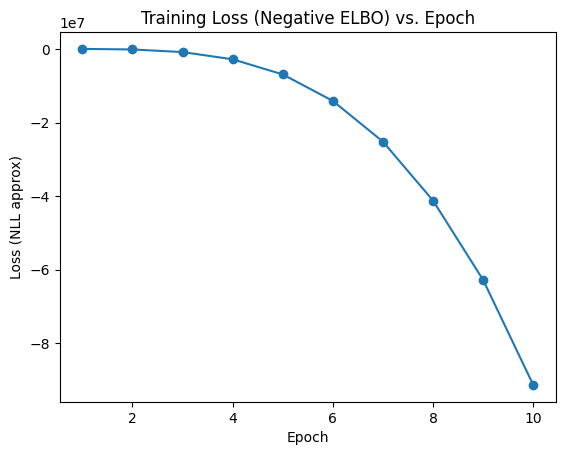

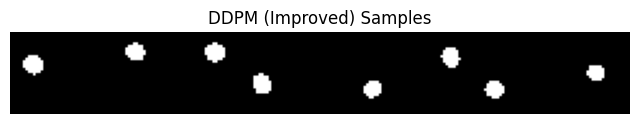

In [34]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x + torch.rand_like(x)/255.),  # dequantize
        transforms.Lambda(lambda x: (x - 0.5)*2.0),                # map to [-1,1]
        transforms.Lambda(lambda x: x.flatten())
    ])
    dataset = datasets.MNIST("./mnist_data", train=True, download=True, transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

    def sigma_one(t):
        return torch.ones_like(t)

    my_unet = ScoreNet(marginal_prob_std=sigma_one).to(device)

    T = 200
    model = DDPM(my_unet, T=T, use_importance_sampling=True).to(device)

    epochs = 10
    losses, times, ema_model = train(model, dataloader, device, epochs=epochs, lr=1e-3, ema=True)

    plt.figure()
    plt.title("Training Loss (Negative ELBO) vs. Epoch")
    plt.plot(range(1, epochs+1), losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss (NLL approx)")
    plt.show()

    # Show samples
    model_for_sampling = ema_model if ema_model else model
    model_for_sampling.eval()
    with torch.no_grad():
        nsamples = 8
        samples = model_for_sampling.module.sample((nsamples, 28*28)).cpu()
        samples = (samples+1)/2  # map [-1,1] to [0,1]
        samples = samples.clamp(0,1).view(-1,1,28,28)
        grid = utils.make_grid(samples, nrow=nsamples)
        plt.figure(figsize=(8,2))
        plt.axis("off")
        plt.title("DDPM (Improved) Samples")
        plt.imshow(grid.permute(1,2,0).numpy(), cmap="gray")
        plt.show()


Using device: cuda
Epoch 1/100 | Loss(ELBO) ~ -8136.0888 +/- 10440.8025
Epoch 2/100 | Loss(ELBO) ~ -226698.6676 +/- 148524.0390
Epoch 3/100 | Loss(ELBO) ~ -1360535.4715 +/- 582461.8733
Epoch 4/100 | Loss(ELBO) ~ -4531454.2032 +/- 1377916.4460
Epoch 5/100 | Loss(ELBO) ~ -11218195.9532 +/- 2691526.3294
Epoch 6/100 | Loss(ELBO) ~ -22870239.0000 +/- 4518391.9529
Epoch 7/100 | Loss(ELBO) ~ -41514848.4340 +/- 7123793.7427
Epoch 8/100 | Loss(ELBO) ~ -68167273.8043 +/- 9794621.0072
Epoch 9/100 | Loss(ELBO) ~ -104310495.0809 +/- 13506614.7282
Epoch 10/100 | Loss(ELBO) ~ -154885560.5447 +/- 19111796.1471
Epoch 11/100 | Loss(ELBO) ~ -214378611.2681 +/- 24175609.6351
Epoch 12/100 | Loss(ELBO) ~ -291797708.3915 +/- 30309905.5425
Epoch 13/100 | Loss(ELBO) ~ -379482199.4213 +/- 38555603.0556
Epoch 14/100 | Loss(ELBO) ~ -489887725.6170 +/- 49568959.5347
Epoch 15/100 | Loss(ELBO) ~ -617875184.0681 +/- 51637768.9990
Epoch 16/100 | Loss(ELBO) ~ -760775787.3021 +/- 65334561.9542
Epoch 17/100 | Loss(ELBO) 

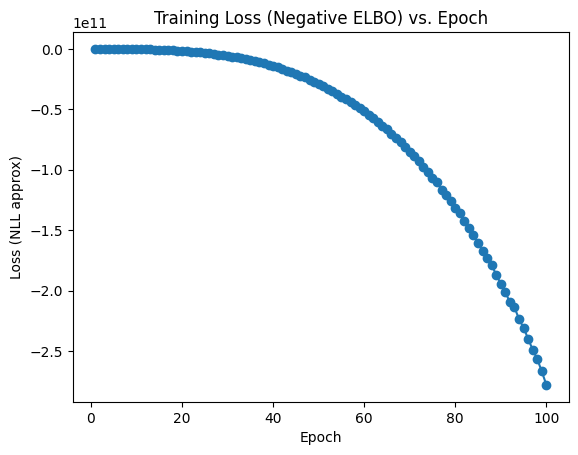

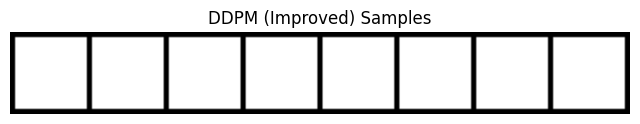

CPU times: user 29min 47s, sys: 4.23 s, total: 29min 51s
Wall time: 30min 1s


In [36]:
%%time

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x + torch.rand_like(x)/255.),  # dequantize
        transforms.Lambda(lambda x: (x - 0.5)*2.0),                # map to [-1,1]
        transforms.Lambda(lambda x: x.flatten())
    ])
    dataset = datasets.MNIST("./mnist_data", train=True, download=True, transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

    # ScoreNet with sigma(t)=1
    def sigma_one(t):
        return torch.ones_like(t)

    my_unet = ScoreNet(marginal_prob_std=sigma_one).to(device)

    T = 200
    model = DDPM(my_unet, T=T, use_importance_sampling=True).to(device)

    epochs = 100
    losses, times, ema_model = train(model, dataloader, device, epochs=epochs, lr=1e-3, ema=True)

    plt.figure()
    plt.title("Training Loss (Negative ELBO) vs. Epoch")
    plt.plot(range(1, epochs+1), losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss (NLL approx)")
    plt.show()

    model_for_sampling = ema_model if ema_model else model
    model_for_sampling.eval()
    with torch.no_grad():
        nsamples = 8
        samples = model_for_sampling.module.sample((nsamples, 28*28)).cpu()
        samples = (samples+1)/2  # map [-1,1] to [0,1]
        samples = samples.clamp(0,1).view(-1,1,28,28)
        grid = utils.make_grid(samples, nrow=nsamples)
        plt.figure(figsize=(8,2))
        plt.axis("off")
        plt.title("DDPM (Improved) Samples")
        plt.imshow(grid.permute(1,2,0).numpy(), cmap="gray")
        plt.show()